# Linear Modeling of House Price

## 1. Introduction

## 2. Preparing the Dataset

In [78]:
import pandas as pd
import numpy as np
from Modules.dataexploration import DataExploration

pd.set_option('display.float', '{:,.2f}'.format)
pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 75)
pd.set_option('display.max_info_columns', 50)

In [79]:
house_df = pd.read_csv('Dataset\jabodetabek_house_data_prcsd.csv')

### 2.1. Subsetting the Test Set for Assessing Prediction

In [80]:
from sklearn.model_selection import train_test_split

X = house_df.drop('price_in_rp', axis=1)
y = house_df.price_in_rp

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=99
)

### 2.2. Missing Values

First let's review missing data from our original dataset (yes, not `train` or `test set`). By evaluating `original dataset`, we analyze the possibility of missing value for both scenarios.

In [81]:
numerical_features = house_df.select_dtypes(exclude=['object', 'category']).columns
DataExploration(house_df).show_nans_or_zeroes('nans', numerical_features)

,Nans Count,Nans Percentage (%),Data Types
price_in_rp,0,0.00,float64
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,32,0.93,float64
bathrooms,28,0.81,float64
land_size_m2,2,0.06,float64
building_size_m2,2,0.06,float64
carports,0,0.00,int64
maid_bedrooms,0,0.00,int64
maid_bathrooms,0,0.00,int64


In [82]:
non_numeric_features = house_df.select_dtypes(include=['object']).columns
DataExploration(house_df).show_nans_or_zeroes('nans', non_numeric_features)

,Nans Count,Nans Percentage (%),Data Types
url,0,0.00,object
title,0,0.00,object
address,0,0.00,object
district,0,0.00,object
city,0,0.00,object
facilities,0,0.00,object
property_type,1,0.03,object
ads_id,4,0.12,object
certificate,140,4.06,object
electricity,0,0.00,object


Remember that those observations (from our original dataset) with missing records may exist in `training set`, `test set` or may be in both. Therefore, we must develop method to handle missing value that works for `training set`, `test set`, and even `potential future data` which we want to predict if any. Possible method:

1. Drop observations that have missing `bathrooms` or `bedrooms`, `land_size` and `building_size` records
2. Drop `building_age`, `year_built`, and `building_orientation` which have a lot of missing value
3. For missing `floors` and `electricity_num`, will be imputed. Features that used for imputation is best choosen according to its correlation coefficient (previous chapter).
4. For missing `certificate`, let's assume `certificate = lainnya`.
5. For missing `property_condition` and `furnishing`, let's assume majority of data.

According to above explanation, it should be noted that if there are any `future data` that we want to predict, the only missing features that can be considered are `floors`, `electricity`, `certificate`, `property_condition` and `furnishing`. Other than that, the prediction can't be performed.

In below codes, note that the imputation is fitted only with `train set` to ensure that the prediction model is isolated from `test set` (avoding data leakage)

In [83]:
from sklearn.impute import SimpleImputer, KNNImputer

# 1. Drop observations that missing vital records
X_train = X_train\
    .dropna(subset=['bedrooms', 'bathrooms', 'building_size_m2', 'land_size_m2'])
y_train = y_train[X_train.index] # remember to also drop the particular index of label data
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
# 2. Drop features with lot of NaN    
X_train = X_train\
    .drop(['building_age', 'year_built', 'building_orientation'], axis=1)
# 3.a. Impute missing `floors`
knn_imputer = KNNImputer(n_neighbors=1)
missing_floors_index = X_train[X_train.floors.isna()].index
features_estimator_floors = ['building_size_m2', 'bedrooms', 'bathrooms', 'floors']
imputer_floors = knn_imputer.fit(X_train[features_estimator_floors])
imputed_data_floors = imputer_floors.transform(X_train[features_estimator_floors])
X_train = X_train.assign(
    floors = imputed_data_floors[:, 3]
)
# 3.b. Impute missing `Electricity`
features_estimator_electricity = [
    'building_size_m2', 'bedrooms', 'bathrooms', 'floors', 'electricity_num'
]
missing_electricity_index = X_train[X_train.electricity_num.isna()].index
imputer_electricity = knn_imputer.fit(X_train[features_estimator_electricity])
imputed_data_electricity = imputer_electricity.transform(X_train[features_estimator_electricity])
X_train = X_train.assign(
    electricity_num = imputed_data_electricity[:, 4]
)
# 4. Impute missing `certificate`
constant_imputer = SimpleImputer(strategy='constant', fill_value='lainnya (ppjb,girik,adat,dll)')
X_train['certificate'] = constant_imputer.fit_transform(X_train[['certificate']]).flatten()
# 5. Impute missing `property_condition` and `furnishing`
frequent_imputer = SimpleImputer(strategy='most_frequent')
X_train['property_condition'] = frequent_imputer\
    .fit_transform(X_train[['property_condition']])\
    .flatten()
X_train['furnishing'] = frequent_imputer\
    .fit_transform(X_train[['furnishing']])\
    .flatten()

Let's see the imputation result:

In [84]:
# missing floor imputation results
show_features = ['building_size_m2', 'land_size_m2', 'bedrooms', 'bathrooms', 'floors']
pd.merge(
    X_train.iloc[missing_floors_index, X_train.columns.get_indexer(show_features)],
    y_train, left_index=True, right_index=True
)

,building_size_m2,land_size_m2,bedrooms,bathrooms,floors,price_in_rp
1265,200.00,187.00,3.00,3.00,2.00,"2,750,000,000.00"
1465,600.00,250.00,3.00,3.00,3.00,"13,000,000,000.00"
1703,250.00,320.00,4.00,4.00,2.00,"8,300,000,000.00"
2425,358.00,200.00,4.00,4.00,3.00,"10,100,000,000.00"


In [85]:
# missing electricity imputation results
show_features = ['building_size_m2', 'land_size_m2', 'bedrooms', 'bathrooms', 'floors', 'electricity_num']
pd.merge(
    X_train\
    .iloc[missing_electricity_index, X_train.columns.get_indexer(show_features)]\
    .head(),
    y_train, left_index=True, right_index=True
)

,building_size_m2,land_size_m2,bedrooms,bathrooms,floors,electricity_num,price_in_rp
5,336.00,136.00,10.00,11.00,4.00,"3,500.00","5,500,000,000.00"
6,240.00,136.00,4.00,4.00,3.00,"2,200.00","6,000,000,000.00"
7,839.00,785.00,6.00,5.00,3.00,"16,500.00","26,000,000,000.00"
32,252.00,250.00,5.00,4.00,2.00,"3,300.00","2,790,000,000.00"
35,91.00,120.00,3.00,2.00,2.00,"2,200.00","2,130,000,000.00"


### 2.3. Unnecessary Features and Features with High Cardinality

In [86]:
cols_to_drop = ['url', 'title', 'address', 'district', 'ads_id', 'facilities', 'property_type', 'electricity']
X_train.drop(cols_to_drop, axis=1, inplace=True)

### 2.4. Conclusion: Prepared Features

In [87]:
numerical_features = X_train.select_dtypes(exclude=['object', 'category']).columns
DataExploration(X_train).show_nans_or_zeroes('nans', numerical_features)

,Nans Count,Nans Percentage (%),Data Types
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,0,0.00,float64
bathrooms,0,0.00,float64
land_size_m2,0,0.00,float64
building_size_m2,0,0.00,float64
carports,0,0.00,int64
maid_bedrooms,0,0.00,int64
maid_bathrooms,0,0.00,int64
floors,0,0.00,float64


In [88]:
non_numeric_features = X_train.select_dtypes(include=['object']).columns
DataExploration(X_train).show_nans_or_zeroes('nans', non_numeric_features)

,Nans Count,Nans Percentage (%),Data Types
city,0,0.00,object
certificate,0,0.00,object
property_condition,0,0.00,object
furnishing,0,0.00,object


### 2.5. Additional: Pipeline for Test Set

#### **Transformer to drop Observations with Missing Records**

In [89]:
from sklearn.base import BaseEstimator, TransformerMixin

class RowsDropper(BaseEstimator, TransformerMixin):
    """ 
    Remove observations that missing any records from features that
    specified in `mandatory_features` 
    """
    def __init__(self, mandatory_features):
        self.mandatory_features = mandatory_features.copy()
        self.dropped_index = []

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        self.dropped_index = X[X[self.mandatory_features].isna()].index
        X_new = X.dropna(subset=self.mandatory_features)
        X_new.reset_index(drop=True, inplace=True)
        return X_new
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, **fit_params).transform(X)

#### **Features-Dropper Transformer**

In [90]:
class FeaturesDropper(BaseEstimator, TransformerMixin):
    def __init__(self, drop_list):
        self.drop_list = drop_list.copy()
        self.cols_dropped = []

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # checking if streamed data has unused features
        self.cols_dropped +=\
            [column for column in X.columns if column in self.drop_list]
        if self.cols_dropped:
            X_new = X.drop(self.cols_dropped, axis=1)
            return X_new
        else:
            return X
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, **fit_params).transform(X)

#### **Transformer for Specific Columns**

In [91]:
class FloorsKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._knn_imputer = KNNImputer(n_neighbors=1)
        self._features_estimator_floors = ['building_size_m2', 'bedrooms', 'bathrooms', 'floors']

    def fit(self, X, y=None):
        X_fit = X.copy()
        self._knn_imputer = self._knn_imputer.fit(X_fit[self._features_estimator_floors])
        return self

    def transform(self, X, y=None):
        X_transf = X.copy()
        imputed_data_floors = self._knn_imputer.transform(X_transf[self._features_estimator_floors])
        X_new = X_transf.assign(
            floors = imputed_data_floors[:, 3]
        )
        return X_new
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, **fit_params).transform(X)

class ElectricityKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._knn_imputer = KNNImputer(n_neighbors=1)
        self._features_estimator_electricity = \
            ['building_size_m2', 'bedrooms', 'bathrooms', 'floors', 'electricity_num']

    def fit(self, X, y=None):
        X_fit = X.copy()
        self._knn_imputer = self._knn_imputer.fit(X_fit[self._features_estimator_electricity])
        return self

    def transform(self, X, y=None):
        X_transf = X.copy()
        imputed_data_electricity = self._knn_imputer.transform(X_transf[self._features_estimator_electricity])
        X_new = X_transf.assign(
            electricity_num = imputed_data_electricity[:, 4]
        )
        return X_new
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, **fit_params).transform(X)

#### **Creating Pipeline for Train-Test Set**

In [92]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config

mandatory_features = ['price_in_rp', 'bedrooms', 'bathrooms', 'building_size_m2', 'land_size_m2']
columns_to_drop = [
            'building_age', 'year_built', 'building_orientation',
            'url', 'title', 'address', 'district', 'ads_id', 'facilities', 
            'property_type', 'electricity'
            ]
rows_dropper = RowsDropper(mandatory_features)
features_dropper = FeaturesDropper(columns_to_drop)
floors_imputer = FloorsKNNImputer()
electricity_imputer = ElectricityKNNImputer()
certificate_imputer = SimpleImputer(strategy='constant', fill_value='lainnya (ppjb,girik,adat,dll)')
features_transf = ColumnTransformer([
    ('certificate_impute', certificate_imputer, ['certificate']),
    ('property_condition_impute', SimpleImputer(strategy='most_frequent'), ['property_condition']),
    ('furnishing_impute', SimpleImputer(strategy='most_frequent'), ['furnishing'])
    ], remainder='passthrough')
dataset_transform_pipeline = make_pipeline(
    rows_dropper,
    features_dropper,
    floors_imputer,
    electricity_imputer,
    features_transf
    )

set_config(display='diagram')
dataset_transform_pipeline

Pipeline(steps=[('rowsdropper',
                 RowsDropper(mandatory_features=['price_in_rp', 'bedrooms',
                                                 'bathrooms',
                                                 'building_size_m2',
                                                 'land_size_m2'])),
                ('featuresdropper',
                 FeaturesDropper(drop_list=['building_age', 'year_built',
                                            'building_orientation', 'url',
                                            'title', 'address', 'district',
                                            'ads_id', 'facilities',
                                            'property_type', 'electricity'])),
                ('floorsknnimputer', Floors...
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('certificate_impute',
                                                  SimpleImputer(fill_value='lainnya '
                                                                           '(ppjb,girik,adat,dll)',
                                                                strategy='constant'),
                                                  ['certificate']),
                                                 ('property_condition_impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['property_condition']),
                                                 ('furnishing_impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['furnishing'])]))])

#### **Demonstrating Pipeline for Train Set**

In [93]:
df_train, df_test =  train_test_split(house_df, test_size=0.1, random_state=99)

In [94]:
transfd_columns = ['certificate', 'property_condition', 'furnishing']
dataset_columns = \
    transfd_columns + [column for column in house_df.drop(columns_to_drop, axis=1) if column not in transfd_columns]

train_set_transfd = pd.DataFrame(
    dataset_transform_pipeline.fit_transform(df_train), 
    columns=dataset_columns)
for column in train_set_transfd.columns:
    train_set_transfd[column] = pd.to_numeric(train_set_transfd[column], errors='ignore')
    
DataExploration(train_set_transfd).show_nans_or_zeroes('nans')

,Nans Count,Nans Percentage (%),Data Types
certificate,0,0.00,object
property_condition,0,0.00,object
furnishing,0,0.00,object
price_in_rp,0,0.00,float64
city,0,0.00,object
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,0,0.00,float64
bathrooms,0,0.00,float64
land_size_m2,0,0.00,float64


In [95]:
# missing floor imputation results
show_features = ['building_size_m2', 'land_size_m2', 'bedrooms', 'bathrooms', 'floors', 'price_in_rp']
train_set_transfd .iloc[missing_floors_index, train_set_transfd .columns.get_indexer(show_features)]

,building_size_m2,land_size_m2,bedrooms,bathrooms,floors,price_in_rp
1265,200.00,187.00,3.00,3.00,2.00,"2,750,000,000.00"
1465,600.00,250.00,3.00,3.00,3.00,"13,000,000,000.00"
1703,250.00,320.00,4.00,4.00,2.00,"8,300,000,000.00"
2425,358.00,200.00,4.00,4.00,3.00,"10,100,000,000.00"


In [96]:
# missing electricity imputation results
show_features = ['building_size_m2', 'land_size_m2', 'bedrooms', 'bathrooms', 'floors', 'electricity_num', 'price_in_rp']
train_set_transfd \
    .iloc[missing_electricity_index, train_set_transfd.columns.get_indexer(show_features)]\
    .head()

,building_size_m2,land_size_m2,bedrooms,bathrooms,floors,electricity_num,price_in_rp
5,336.00,136.00,10.00,11.00,4.00,"3,500.00","5,500,000,000.00"
6,240.00,136.00,4.00,4.00,3.00,"2,200.00","6,000,000,000.00"
7,839.00,785.00,6.00,5.00,3.00,"16,500.00","26,000,000,000.00"
32,252.00,250.00,5.00,4.00,2.00,"3,300.00","2,790,000,000.00"
35,91.00,120.00,3.00,2.00,2.00,"2,200.00","2,130,000,000.00"


As explained before, the advantage of using pipeline is to assure that necessary dataset transformation can also be applied for the data independent of `train-test set`. As an example, here we will transform the *suspicious* house data records (as identified in Chapter 2) that has been isolated for analysis purposes.

In [97]:
suspicious_records = pd.read_csv('Dataset/suspicious_records.csv')
sus_set = pd.DataFrame(
    dataset_transform_pipeline.transform(suspicious_records), 
    columns=dataset_columns)

for column in sus_set.columns:
    sus_set[column] = pd.to_numeric(sus_set[column], errors='ignore')

In [98]:
DataExploration(sus_set).show_nans_or_zeroes('nans')

,Nans Count,Nans Percentage (%),Data Types
certificate,0,0.00,object
property_condition,0,0.00,object
furnishing,0,0.00,object
price_in_rp,0,0.00,float64
city,0,0.00,object
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,0,0.00,int64
bathrooms,0,0.00,int64
land_size_m2,0,0.00,float64


#### **Demonstrating Pipeline for Test Set**

In [99]:
test_set_transfd = pd.DataFrame(dataset_transform_pipeline.transform(df_test), columns=dataset_columns)
for column in test_set_transfd.columns:
    test_set_transfd[column] = pd.to_numeric(test_set_transfd[column], errors='ignore')
DataExploration(test_set_transfd).show_nans_or_zeroes('nans')

,Nans Count,Nans Percentage (%),Data Types
certificate,0,0.00,object
property_condition,0,0.00,object
furnishing,0,0.00,object
price_in_rp,0,0.00,float64
city,0,0.00,object
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,0,0.00,float64
bathrooms,0,0.00,float64
land_size_m2,0,0.00,float64


#### **Exporting Train-Test Set for other Models**

In [100]:
from joblib import dump

dump(dataset_transform_pipeline, 'Output\dataset_transform_pipeline.joblib')

['Output\\dataset_transform_pipeline.joblib']

In [101]:
# Train set
X_train = train_set_transfd.drop('price_in_rp', axis=1)
y_train = train_set_transfd[['price_in_rp']]
# Test set
X_test = test_set_transfd.drop('price_in_rp', axis=1)
y_test = test_set_transfd[['price_in_rp']]
# Export to csv
X_train.to_csv('Dataset/X_train.csv')
y_train.to_csv('Dataset/y_train.csv')
X_test.to_csv('Dataset/X_test.csv')
y_test.to_csv('Dataset/y_test.csv')


## 3. Linear Modeling: Ordinary Least Square

### 3.1. Simple Linear Regression

In [102]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.api import OLS
from statsmodels.tools import add_constant

X = train_set_transfd
X = add_constant(X)
# regression formula
f = 'price_in_rp ~ building_size_m2'
lm = smf.ols(formula=f, data=X)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price_in_rp   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     2609.
Date:                Mon, 31 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:49:20   Log-Likelihood:                -74037.
No. Observations:                3068   AIC:                         1.481e+05
Df Residuals:                    3066   BIC:                         1.481e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -9.839e+08   1.64e+08     -5.992      0.000   -1.31e+09   -6.62e+08
building_size_m2  2.667e+07   5.22e+05     51.074      0.000    2.56e+07    2.77e+07
==============================================================================
Omnibus:                     5588.374   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11784169.280
Skew:                          12.971   Prob(JB):                         0.00
Kurtosis:                     305.508   Cond. No.                         391.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

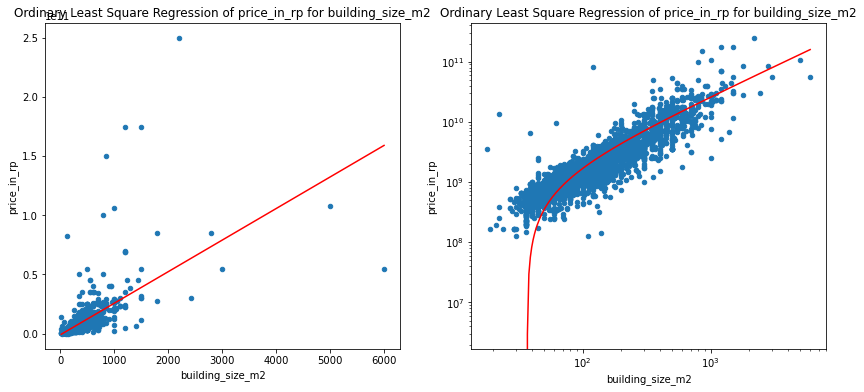

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

# linear OLS
y_linear = results.predict(X)
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    X.plot(kind='scatter', x='building_size_m2', y='price_in_rp', ax=ax_)
    ax_.plot(
        np.sort(X.building_size_m2),
        y_linear[np.argsort(X.building_size_m2)], color='r'
    )
    ax_.set_title('Ordinary Least Square Regression of price_in_rp for building_size_m2')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
 

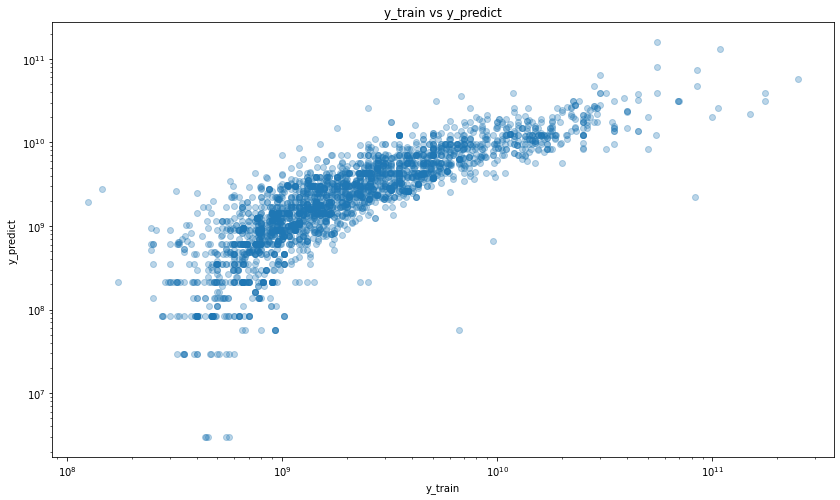

In [104]:
y_predict = results.predict(exog=X).values.reshape(-1, 1)
y = y_train.price_in_rp.values.reshape(-1, 1)

fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(x=y, y=y_predict, alpha=0.3)
ax.set_title('y_train vs y_predict')
ax.set_xlabel('y_train')
ax.set_ylabel('y_predict')
ax.set_xscale('log')
ax.set_yscale('log')

Text(0, 0.5, 'y_predict')

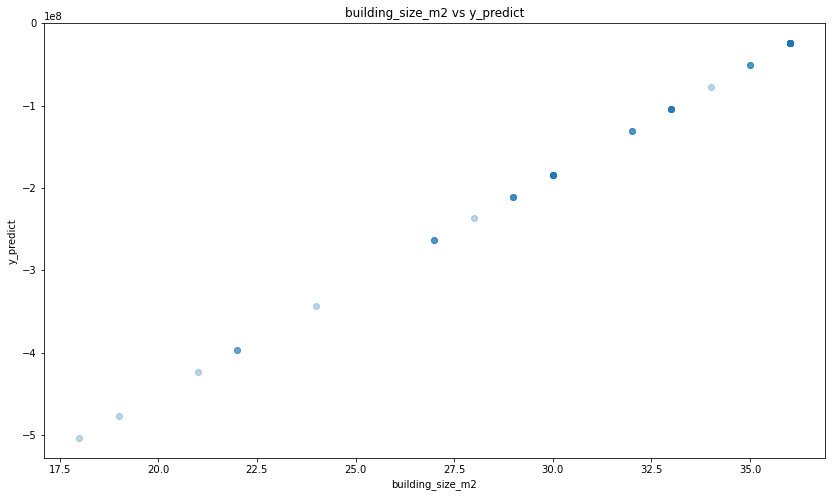

In [105]:
y_predict_w_obs = np.c_[y_predict, X.building_size_m2.values]
negative_price_predict = y_predict_w_obs[y_predict_w_obs[:, 0] < 0]
fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(x=negative_price_predict[:, 1], y=negative_price_predict[:, 0], alpha=0.3)
ax.set_title('building_size_m2 vs y_predict')
ax.set_xlabel('building_size_m2')
ax.set_ylabel('y_predict')

#### **Residual Analysis of Simple Linear Regression**

Text(0, 0.5, 'residual')

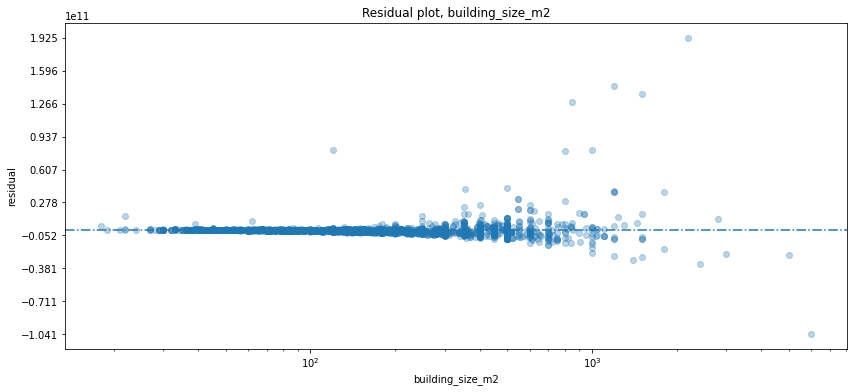

In [106]:
y_predict = results.predict(exog=X).values.reshape(-1, 1)
y = y_train.price_in_rp.values.reshape(-1, 1)
resid = y - y_predict
# matpltlib plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(x=X_train.building_size_m2.values.reshape(-1, 1), y=resid, alpha=0.3)
ax.axhline(y=resid.mean(), linestyle='-.')
ax.set_title('Residual plot, building_size_m2')
ax.set_yticks(np.linspace(resid.min(), resid.max(), 10))
ax.set_xscale('log')
ax.set_xlabel('building_size_m2')
ax.set_ylabel('residual')

Text(0, 0.5, 'Residual')

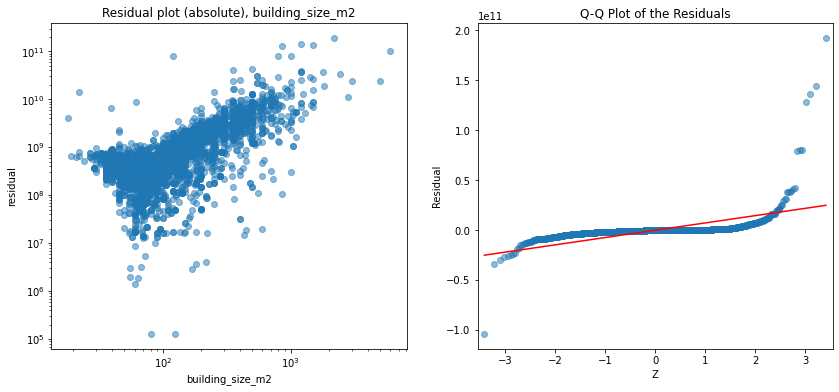

In [107]:
from statsmodels.graphics.gofplots import ProbPlot

# residual plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].scatter(x=X_train.building_size_m2.values.reshape(-1, 1), y=abs(resid), alpha=0.5)
ax[0].set_title('Residual plot (absolute), building_size_m2')
ax[0].set_yticks(np.linspace(resid.min(), resid.max(), 10))
ax[0].set_xscale('log') 
ax[0].set_yscale('log', nonpositive='mask')
ax[0].set_xlabel('building_size_m2')
ax[0].set_ylabel('residual')
# Q-Q Plot
pplot = ProbPlot(resid.flatten())
pplot.qqplot(ax=ax[1], alpha=0.5, line='s')
ax[1].set_title('Q-Q Plot of the Residuals')
ax[1].set_xlabel('Z')
ax[1].set_ylabel('Residual')

#### **Inference of `building_size_m2` parameter**

We are going to use `paired bootstrap` to estimate distribution of `building_size_m2` parameter.

In [108]:
from scipy.stats import bootstrap

def coefficient(x, y):
    x_ = x.copy()
    y_ = y.copy()
    rows = x_.size
    np.c_[x_, np.repeat(1, rows)]
    lm = OLS(y_, x_)
    results = lm.fit()
    coeff = results.params[0]
    return coeff

X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
sample = ((X, y))
bootstrap_res = bootstrap(
    sample, coefficient, vectorized=False, paired=True, random_state=99, 
    confidence_level=0.95
)
pd.DataFrame(
    [{'interval': 'OLS bootstrap', 
    'ci_low': bootstrap_res.confidence_interval[0],
    'ci_high': bootstrap_res.confidence_interval[1]},
    ]
)

,interval,ci_low,ci_high
0,OLS bootstrap,"19,912,011.56","29,830,707.55"


Compare it to interval calculated using *student's t distribution* based on standard error of the coefficient:

In [109]:
results.summary(alpha=0.05).tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-9.839e+08,1.64e+08,-5.992,0.000,-1.31e+09,-6.62e+08
building_size_m2,2.667e+07,5.22e+05,51.074,0.000,2.56e+07,2.77e+07


For large sample, it is known that inference of regression coefficient *using student's t-distribution* will covers the *violation of normality* since *t-distribution will converge to normal*, but we won't know for sure how large of `n sample` is large enough for our dataset. But what is known that the largeness of `n` is highly affected by dataset skewness, in which our dataset suffers highly. Our model with `building_size_m2` also suffers from `non-constant variance`, which also affect the validity of our *t-distribution*.

The confidence interval is quite narrow (compared to the bootstrap result). The safer choice will be the `bootstrap confidence interval` due to reasons above.

As we hope that the bootstrap result portrays the true distribution of coefficient (confidently if we are very sure the dataset covers the population data well enough), the possibility of `building_size_m2` value can be identified by using below bootstrap plot.

Text(0, 0.5, 'coeff value')

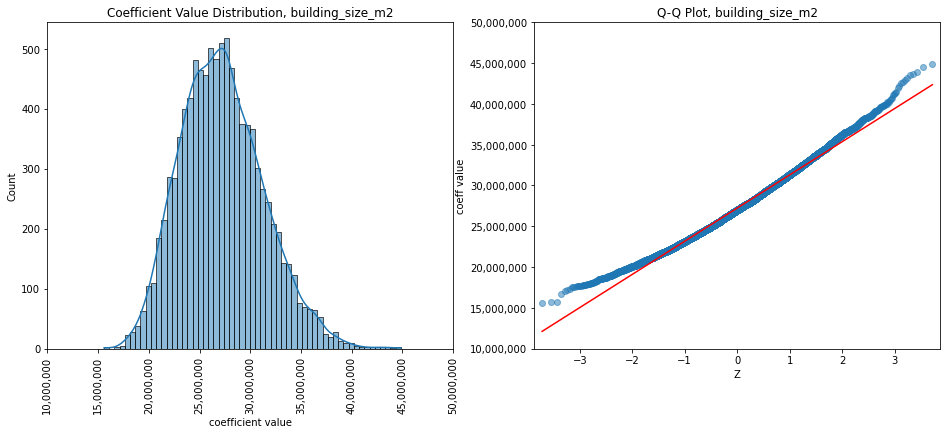

In [110]:
def coefficient_with_repl(x, y):
    rows = x.size
    resample_idx = np.random.choice(rows, size=rows, replace=True)
    x_ = x[resample_idx]
    y_ = y[resample_idx]
    x_ = np.c_[x_, np.repeat(1, rows)]
    lm = OLS(y_, x_)
    results = lm.fit()
    coeff = results.params[0]
    return coeff

# determining parameters for bootstrap
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
n_iter = 9999
# bootstrapping
a = np.empty((n_iter, 1))
bootstrap_coeff_value = np.apply_along_axis(lambda x: coefficient_with_repl(X, y), 1, a)
# plotting bootstrap result
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(
    x=bootstrap_coeff_value, kde=True, ax=ax[0]
    )
# Q-Q Plot
pplot = ProbPlot(bootstrap_coeff_value.flatten())
pplot.qqplot(ax=ax[1], alpha=0.5, line='s')
xticks = ax[0].get_xticks()
ax[0].set_title('Coefficient Value Distribution, building_size_m2')
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(['{:,.0f}'.format(x) for x in xticks], rotation=90)
ax[0].set_xlabel('coefficient value')
yticks = ax[1].get_yticks()
ax[1].set_yticks(yticks)
ax[1].set_yticklabels(['{:,.0f}'.format(y) for y in yticks])
ax[1].set_title('Q-Q Plot, building_size_m2')
ax[1].set_xlabel('Z')
ax[1].set_ylabel('coeff value')


As seen above, the coefficient distribution is quite skewed, which not yet close to our `symmetric t-distribution` caused by incorrect t-distribution due to non-constant variance. 

The distribution is also fat-tailed, in which the sample size effect doesn't quite make the distribution *converge to normality* yet.

Both the skewed and fat-tailed distribution will be considered in `BCa Corrected Interval` that has been calculated by using `scipy.stats.bootstrap` program, making the `bootstrap ci` resulting in the more confidence choice of CI calculation.

#### **Inference of Mean Response from Simple Regression**

Text(0.5, 0, 'Prediction of House Price, in Rupiah')

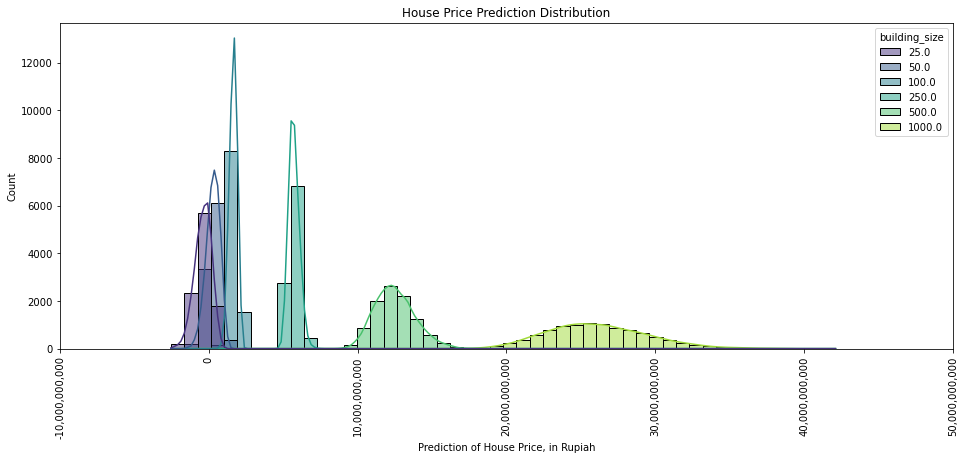

In [111]:
def prediction_with_repl(x, y, x_fixed):
    rows = x.size
    resample_idx = np.random.choice(rows, size=rows, replace=True)
    x_ = x[resample_idx]
    y_ = y[resample_idx]
    x_ = np.c_[x_, np.repeat(1, rows)]
    x_predict = np.array([x_fixed, 1])
    lm = OLS(y_, x_)
    results = lm.fit()
    y_predict = results.predict(x_predict)
    return float(y_predict)

X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
n_iter = 9999
# bootstrapping
building_sizes = [25, 50, 100, 250, 500, 1000]
a = np.empty((n_iter, 1))
prediction_dist = np.empty((1, 2))
for building_size in building_sizes: 
    prediction = np.c_[
        np.apply_along_axis(lambda x: prediction_with_repl(X, y, building_size), 1, a), 
        np.repeat(building_size, 9999).reshape(-1, 1)
    ]
    prediction_dist = np.r_[
        prediction_dist, prediction
    ]
# plotting bootstrap result
fig, ax = plt.subplots(figsize=(16, 6))
palette = sns.color_palette('viridis', 6)
prediction_dist_df = pd.DataFrame(prediction_dist[1:-1, :], columns=['prediction', 'building_size'])
sns.histplot(
    data=prediction_dist_df, x='prediction', 
    hue='building_size', kde=True, ax=ax, bins=50, palette=palette
    )
xticks = ax.get_xticks()
ax.set_title(f'House Price Prediction Distribution')
ax.set_xticks(xticks)
ax.set_xticklabels(['{:,.0f}'.format(x) for x in xticks], rotation=90)
ax.set_xlabel('Prediction of House Price, in Rupiah')


Text(0.5, 1.0, 'Ordinary Least Square Regression of price_in_rp for building_size_m2')

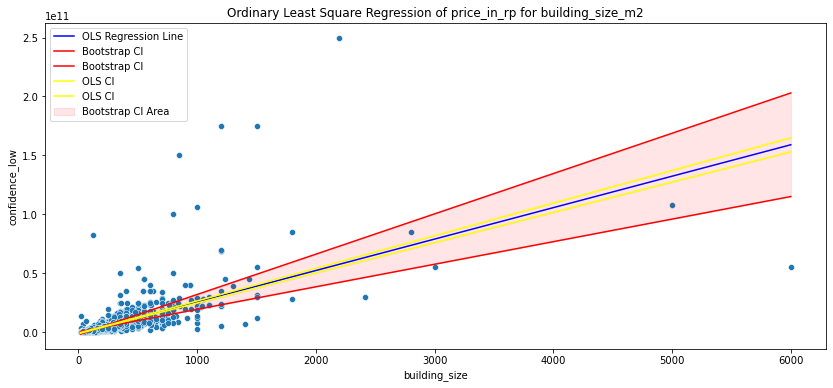

In [112]:
def prediction(x, y, x_fixed):
    x_predict = np.array([1, x_fixed])
    lm = OLS(y, add_constant(x))
    results = lm.fit()
    y_predict = results.predict(x_predict)
    return float(y_predict)

X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
# prediction
observation_index = np.round(np.linspace(0, len(X) - 1, 10)).astype(int)
observations = X[X.argsort()][observation_index]
lm = OLS(y, add_constant(X))
results = lm.fit()
y_predict = results.predict(add_constant(observations))
# bootstrapping
n_iter = 9999
a = np.empty((n_iter, 1))
confidence_low = []
confidence_high = []
for building_size in observations: 
    ci_l, ci_h = [float(ci) for ci in bootstrap(
        data=sample,
        statistic=lambda x,y: prediction(x, y, building_size),
        vectorized=False, paired=True, random_state=99, confidence_level=0.95
        ).confidence_interval
    ]
    confidence_low.append(ci_l)
    confidence_high.append(ci_h)
confidence_interval_boots = pd.DataFrame({
    'prediction_mean': y_predict,
    'confidence_low': confidence_low,
    'confidence_high': confidence_high,
    'building_size': observations
})
ols_interval = results.get_prediction(add_constant(X)).summary_frame(alpha=0.05)
ols_interval_low = ols_interval.mean_ci_lower
ols_interval_high = ols_interval.mean_ci_upper
# plot
fig, ax = plt.subplots(figsize=(14, 6))
sns.scatterplot(x=X, y=y, ax=ax)
sns.lineplot(
    x=np.sort(observations), y=y_predict[np.argsort(observations)], 
    color='b', ax=ax, linestyle='-',label='OLS Regression Line')
sns.lineplot(
    data=confidence_interval_boots, 
    x='building_size', y='confidence_low', color='r', ax=ax, label='Bootstrap CI')
sns.lineplot(
    data=confidence_interval_boots, 
    x='building_size', y='confidence_high', color='r', ax=ax, label='Bootstrap CI')
ax.fill_between(
    data=confidence_interval_boots,
    x='building_size', y1='confidence_high', y2='confidence_low', 
    color='red', alpha=0.1, label='Bootstrap CI Area'
)
sns.lineplot(
    x=X, y=ols_interval_low, color='yellow', ax=ax, label='OLS CI')
sns.lineplot(
    x=X, y=ols_interval_high, color='yellow', ax=ax, label='OLS CI')
ax.fill_between(
    x=X, y1=ols_interval_low, y2=ols_interval_high, 
    color='y', alpha=0.1, label='OLS CI Area'
)

ax.set_title('Ordinary Least Square Regression of price_in_rp for building_size_m2')


In [113]:
confidence_interval_boots[confidence_interval_boots.building_size == 100]

,prediction_mean,confidence_low,confidence_high,building_size
4,"1,683,317,355.73","1,222,324,027.05","2,268,034,778.14",100.00


#### **Prediction Interval of Simple Regression**

Prediction interval of a linear regression is an interval of plausible values of future Y at a specific value of parameter *x\**, which accounts for *Variance of mean response Y caused by variability of regression coefficient, which accounted in regression model* and *Variability caused by error term which can't be explained in regression model*. 

Recall from previous section, our *R2* value for this model is less than 0.5, explains that there were variability that can't be explained by the simple linear model. Plot of *Y_obs vs Y_predicted* also shows non-linearity of the response by using only `building_size_m2`.

The error term variability can also be seen in residual plot, where the residual is quite condensed in small `building_size_m2` but continue to spread out in large `building_size_m2` (i.e. indicating non-constant variance).

Theoretical prediction interval of OLS relies heavily on *normality assumption* and *constant variance*, which is violated by our simple linear model. I can assure that there is no valid OLS prediction interval for our simple linear regression model.

Let's see the calculated prediction interval by our Simple Linear Model, which is simply calculated by assumming the normality and constant variance is valid.

Text(0.5, 1.0, 'Ordinary Least Square Regression of price_in_rp for building_size_m2')

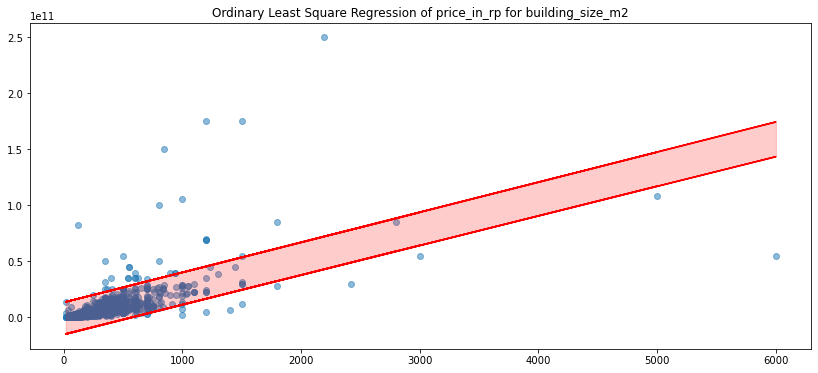

In [114]:
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
lm = OLS(y, add_constant(X))
results = lm.fit()
y_predict = results.get_prediction(add_constant(X)).summary_frame(0.05)
pi_lower = y_predict.obs_ci_lower
pi_upper = y_predict.obs_ci_upper
# plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(x=X, y=y, alpha=0.5)
ax.plot(X, pi_lower, color='r', label='Lower Prediction Interval')
ax.plot(X, pi_upper, color='r', label='Upper Prediction Interval')
ax.fill_between(
    x=np.sort(X), y1=pi_lower[np.argsort(X)], y2=pi_upper[np.argsort(X)], alpha=0.2, color='r'
)
ax.set_title('Ordinary Least Square Regression of price_in_rp for building_size_m2')

#### **Outliers Detection: Studentized Residual, Leverage Point, Cook Distance**

Text(0.5, 0, 'building_size_m2')

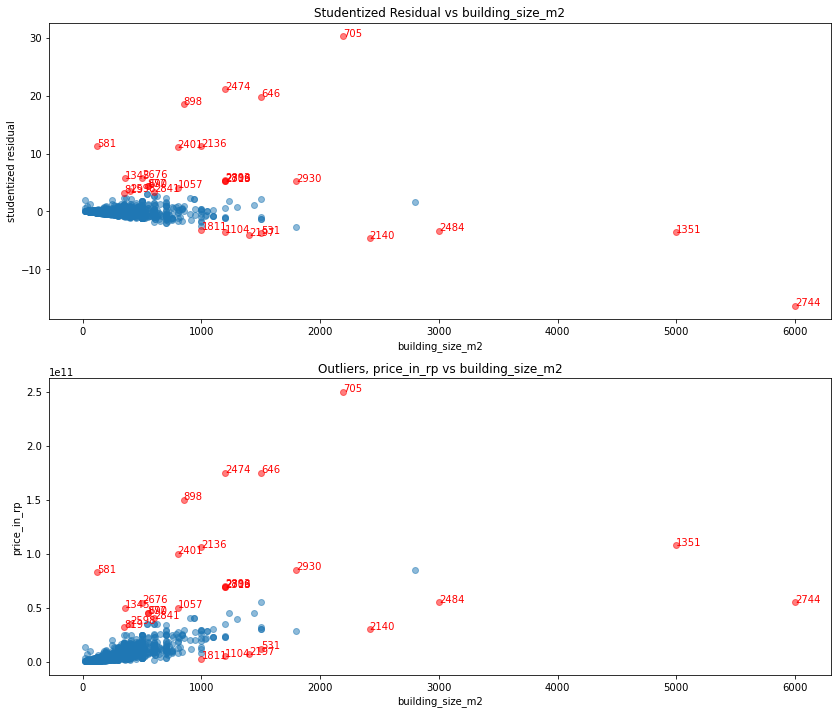

In [115]:
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
lm = OLS(y, add_constant(X))
results = lm.fit()
student_resid = results.outlier_test()[:, 0]
outlier_obs = ((student_resid > 3) | (student_resid < -3))
outlier_obs_index = np.where(outlier_obs)[0]
# plot
fig, ax = plt.subplots(2, 1, figsize=(14, 12))
# Studentized Residual Plot
ax[0].scatter(x=X[~outlier_obs], y=student_resid[~outlier_obs], alpha=0.5)
ax[0].scatter(x=X[outlier_obs], y=student_resid[outlier_obs], alpha=0.5, color='r', label='Outliers')
for x, student_resid, index in np.c_[X[outlier_obs], student_resid[outlier_obs], outlier_obs_index]:
    ax[0].text(x=x, y=student_resid, s=str(int(index)), color='r')
ax[0].set_ylabel('studentized residual')
ax[0].set_xlabel('building_size_m2')
ax[0].set_title('Studentized Residual vs building_size_m2')
# Observations Plot
ax[1].scatter(x=X[~outlier_obs], y=y[~outlier_obs], alpha=0.5)
ax[1].scatter(x=X[outlier_obs], y=y[outlier_obs], alpha=0.5, color='r', label='Outliers')
for x, y, index in np.c_[X[outlier_obs], y[outlier_obs], outlier_obs_index]:
    ax[1].text(x=x, y=y, s=str(int(index)), color='r')
ax[1].set_title('Outliers, price_in_rp vs building_size_m2')
ax[1].set_ylabel('price_in_rp')
ax[1].set_xlabel('building_size_m2')

Text(0.5, 0, 'building_size_m2')

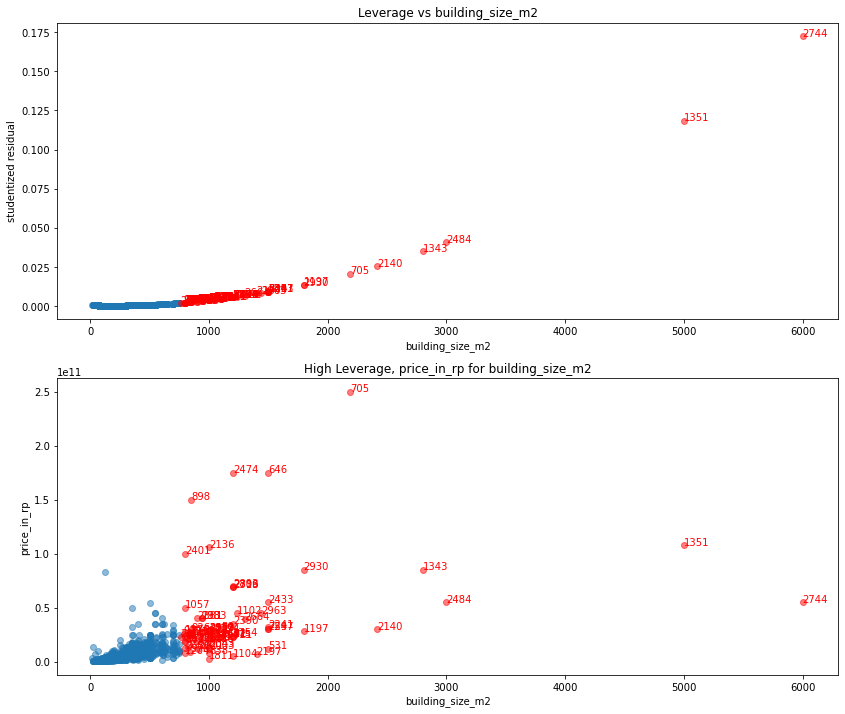

In [116]:
# getting leverage statistics
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
lm = OLS(y, add_constant(X))
results = lm.fit()
leverage = results.get_influence().hat_matrix_diag
high_leverag_tresh = 3 * (add_constant(X).shape[1]) / (add_constant(X).shape[0])
high_leverage_obs = (leverage > high_leverag_tresh)
high_leverage_obs_index = np.where(high_leverage_obs)[0]
# Plot Leverage Statistics
fig, ax = plt.subplots(2, 1, figsize=(14, 12))
ax[0].scatter(
    x=X[~high_leverage_obs], y=leverage[~high_leverage_obs], alpha=0.5)
ax[0].scatter(
    x=X[high_leverage_obs], y=leverage[high_leverage_obs], 
    alpha=0.5, color='r', label='high leverage')
for x, leverage, index in np.c_[X[high_leverage_obs], leverage[high_leverage_obs], high_leverage_obs_index]:
    ax[0].text(x=x, y=leverage, s=str(int(index)), color='r')
ax[0].set_ylabel('studentized residual')
ax[0].set_xlabel('building_size_m2')
ax[0].set_title('Leverage vs building_size_m2')
# Observations Plot
ax[1].scatter(x=X[~high_leverage_obs], y=y[~high_leverage_obs], alpha=0.5)
ax[1].scatter(x=X[high_leverage_obs], y=y[high_leverage_obs], alpha=0.5, color='r', label='Outliers')
for x, y, index in np.c_[X[high_leverage_obs], y[high_leverage_obs], high_leverage_obs_index]:
    ax[1].text(x=x, y=y, s=str(int(index)), color='r')
ax[1].set_title('High Leverage, price_in_rp for building_size_m2')
ax[1].set_ylabel('price_in_rp')
ax[1].set_xlabel('building_size_m2')

Text(0.5, 0, 'building_size_m2')

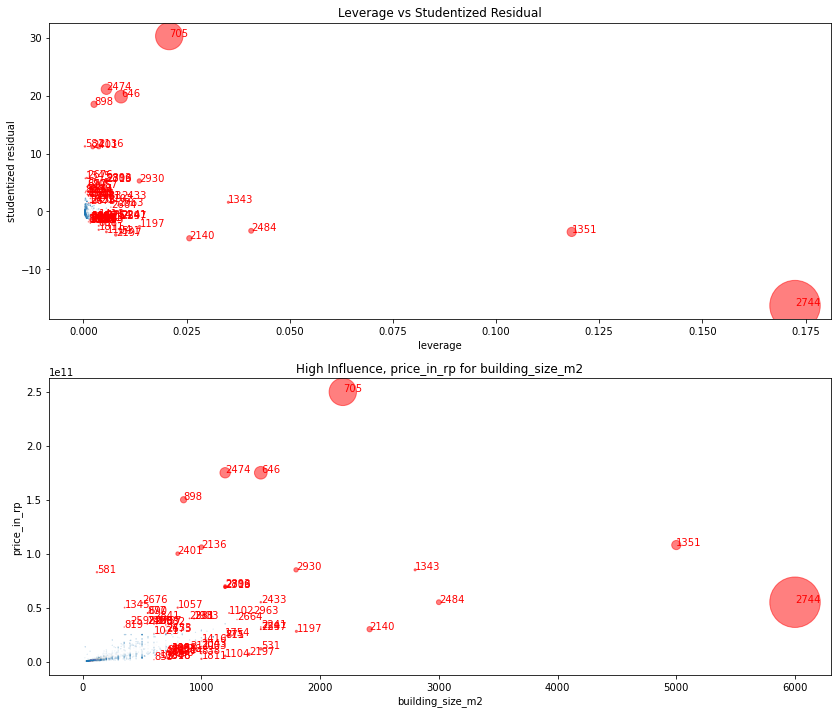

In [117]:
# Cook Distance
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
lm = OLS(y, add_constant(X))
results = lm.fit()
student_resid = results.outlier_test()[:, 0]
leverage = results.get_influence().hat_matrix_diag
cooks_dist = results.get_influence().cooks_distance[0]
high_influence_obs = (cooks_dist > 4 / (add_constant(X).shape[0] - add_constant(X).shape[1]))
high_influence_obs_index = np.where(high_influence_obs)[0]
# High Influence Plot
fig, ax = plt.subplots(2, 1, figsize=(14, 12))
ax[0].scatter(
    x=leverage[~high_influence_obs], y=student_resid[~high_influence_obs], 
    s= cooks_dist[~high_influence_obs] * 100, alpha=0.5)
ax[0].scatter(
    x=leverage[high_influence_obs], y=student_resid[high_influence_obs], 
    alpha=0.5, color='r', s=cooks_dist[high_influence_obs] * 100,
    label='high influence')
for lev, stud_resid, index in np.c_[
    leverage[high_influence_obs], student_resid[high_influence_obs], high_influence_obs_index]:
    ax[0].text(x=lev, y=stud_resid, s=str(int(index)), color='r')
ax[0].set_ylabel('studentized residual')
ax[0].set_xlabel('leverage')
ax[0].set_title('Leverage vs Studentized Residual')
# Observations Plot
ax[1].scatter(
    x=X[~high_influence_obs], y=y[~high_influence_obs], 
    s=cooks_dist[~high_influence_obs] * 100, alpha=0.5)
ax[1].scatter(
    x=X[high_influence_obs], y=y[high_influence_obs], 
    s=cooks_dist[high_influence_obs] * 100, alpha=0.5, color='r', label='Outliers')
for x, y, index in np.c_[X[high_influence_obs], y[high_influence_obs], high_influence_obs_index]:
    ax[1].text(x=x, y=y, s=str(int(index)), color='r')
ax[1].set_title('High Influence, price_in_rp for building_size_m2')
ax[1].set_ylabel('price_in_rp')
ax[1].set_xlabel('building_size_m2')

In [118]:
X_train.iloc[[11, 493], :16].T

,11,493
certificate,shm - sertifikat hak milik,shm - sertifikat hak milik
property_condition,bagus,baru
furnishing,unfurnished,unfurnished
city,Depok,Depok
lat,-6.40,-6.37
long,106.77,106.82
bedrooms,1.00,2.00
bathrooms,1.00,1.00
land_size_m2,72.00,46.00
building_size_m2,43.00,36.00


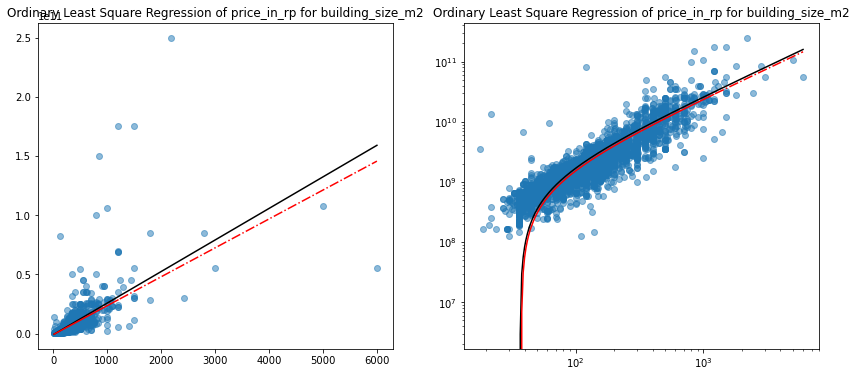

In [119]:
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
lm_1 = OLS(y, add_constant(X))
lm_2 = OLS(y[~high_influence_obs], add_constant(X[~high_influence_obs]))
prediction_range = np.max(X[~high_influence_obs])
results_1 = lm_1.fit()
results_2 = lm_2.fit()
y_predict_1 = results_1.predict(add_constant(X))
y_predict_2 = results_2.predict(add_constant(X[X <= prediction_range]))
y_predict_2_extr = results_2.predict(add_constant(X[X > prediction_range]))
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    ax_.scatter(X, y, alpha=0.5)
    ax_.plot(
        np.sort(X),
        y_predict_1[np.argsort(X)], color='black',
        label='OLS Regression, original dataset'       
    )
    ax_.plot(
        np.sort(X[X <= prediction_range]),
        y_predict_2[np.argsort(X[X <= prediction_range])], color='r',
        label='OLS Regression, w/o outliers'
    )
    ax_.plot(
        np.sort(X[X > prediction_range]),
        y_predict_2_extr[np.argsort(X[X > prediction_range])], linestyle='-.', color='r',
        label='OLS Regression, w/o outliers'
    )    
    ax_.set_title('Ordinary Least Square Regression of price_in_rp for building_size_m2')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [120]:
results_2.summary().tables[0]

Dep. Variable:,y,R-squared:,0.754
Model:,OLS,Adj. R-squared:,0.754
Method:,Least Squares,F-statistic:,9173.
Date:,"Mon, 31 Oct 2022",Prob (F-statistic):,0.00
Time:,14:56:06,Log-Likelihood:,-68680.
No. Observations:,2998,AIC:,1.374e+05
Df Residuals:,2996,BIC:,1.374e+05
Df Model:,1,,
Covariance Type:,nonrobust,,


In [121]:
results_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-9.215e+08,5.75e+07,-16.033,0.000,-1.03e+09,-8.09e+08
x1,2.443e+07,2.55e+05,95.773,0.000,2.39e+07,2.49e+07


In [122]:
def coefficient(x, y):
    x_ = x.copy()
    y_ = y.copy()
    rows = x_.size
    np.c_[x_, np.repeat(1, rows)]
    lm = OLS(y_, x_)
    results = lm.fit()
    coeff = results.params[0]
    return coeff

X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
sample_1 = ((X, y))
sample_2 = ((X[~high_influence_obs], y[~high_influence_obs]))
bootstrap_res_1 = bootstrap(
    sample_1, coefficient, vectorized=False, paired=True, random_state=99, 
    confidence_level=0.95
)
bootstrap_res_2 = bootstrap(
    sample_2, coefficient, vectorized=False, paired=True, random_state=99, 
    confidence_level=0.95
)
pd.DataFrame([
    {'model': 'OLS, full dataset', 
    'ci_low': bootstrap_res_1.confidence_interval[0],
    'ci_high': bootstrap_res_1.confidence_interval[1]},
    {'model': 'OLS, w/o outliers', 
    'ci_low': bootstrap_res_2.confidence_interval[0],
    'ci_high': bootstrap_res_2.confidence_interval[1]}
    ])

,model,ci_low,ci_high
0,"OLS, full dataset","19,912,011.56","29,830,707.55"
1,"OLS, w/o outliers","20,730,438.17","22,201,817.77"


#### **Conclusion: Simple Linear Regression**

In [123]:
# def residual_distribution(x, y_estimate, x_pred, y_pred, adj_resid):
#     X_ = x.copy()
#     y_estimate_ = y_estimate.copy()
#     adj_resid_ = adj_resid.copy()
#     y = y_estimate_ + adj_resid_
#     lm_boots = OLS(y, add_constant(X_))
#     result_boots = lm_boots.fit()
#     y_boots = result_boots.predict(add_constant(X_))
#     residual_boots = y - y_boots
#     leverage_boots = result_boots.get_influence().hat_matrix_diag
#     s_boots = residual_boots / np.sqrt(1 - leverage_boots)
#     adj_resids_boots = s_boots - np.mean(s_boots)
#     y_pred_boots = result_boots.predict(np.array([1, x_pred]))
#     residual_future = \
#         y_pred - float(y_pred_boots) + float(np.random.choice(adj_resids_boots, 1))
#     return residual_future
    
# X = X_train['building_size_m2'].values
# y = y_train['price_in_rp'].values
# # prediction
# lm = OLS(y, add_constant(X))
# results = lm.fit()
# y_predict = results.predict(add_constant(X))
# # calculate adjusted residual
# leverage_obs = results.get_influence().hat_matrix_diag
# residual = y - y_predict
# s = residual / np.sqrt(1 - leverage_obs)
# adj_resid = s - np.mean(s)
# # bootstrapping interval
# observation_index = np.round(np.linspace(0, len(X) - 1, 5)).astype(int)
# x_future = X[X.argsort()][observation_index]
# y_future = results.predict(add_constant(x_future))
# residual_int_l = []
# residual_int_h = []
# sample = (adj_resid, )

# for x, y in np.c_[x_future, y_future]:
#     interval_l, interval_h = [float(ci) for ci in bootstrap(
#         data=sample,
#         statistic=lambda adj_resids: residual_distribution(X, y_predict, x, y, adj_resids),
#         vectorized=False, random_state=99, confidence_level=0.95, method='basic'
#         ).confidence_interval
#     ]
#     residual_int_l.append(interval_l)
#     residual_int_h.append(interval_h)
# pi_l = y_future + np.array(residual_int_l)
# pi_h = y_future + np.array(residual_int_h)
# prediction_interval_df = pd.DataFrame({
#     'building_size': x_future,
#     'prediction': y_future,
#     'error_l': np.array(residual_int_l),
#     'error_h': np.array(residual_int_h),
#     'pi_l': pi_l,
#     'pi_h': pi_h
#     })
    
# prediction_interval_df

In [124]:
# X = X_train['building_size_m2'].values
# y = y_train['price_in_rp'].values
# # plot
# fig, ax = plt.subplots(figsize=(14, 6))
# sns.scatterplot(x=X, y=y, ax=ax)
# sns.lineplot(x=x_linear['building_size_m2'], y=y_linear, color='r', ax=ax)
# sns.lineplot(
#     data=prediction_interval_df, 
#     x='building_size', y='pi_l', color='g', ax=ax)
# sns.lineplot(
#     data=prediction_interval_df, 
#     x='building_size', y='pi_h', color='g', ax=ax)
# ax.fill_between(
#     data=prediction_interval_df,
#     x='building_size', y1='pi_h', y2='pi_l', alpha=0.1
# )
# ax.set_title('Ordinary Least Square Regression of price_in_rp for building_size_m2')

### 3.2. Multiple Linear Regression

In [125]:
numerical_features = \
    X_train.select_dtypes(exclude=['object', 'category']).drop(['lat', 'long'], axis=1).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
f = 'price_in_rp ~ '\
    + ' + '.join(numerical_features) + ' + '\
    + ' + '.join(['C(' + feature + ')' for feature in categorical_features])
lm = OLS.from_formula(f, data=train_set_transfd)
results = lm.fit()

What have we done using above codes?

1. 
2.

Text(0, 0.5, 'residual')

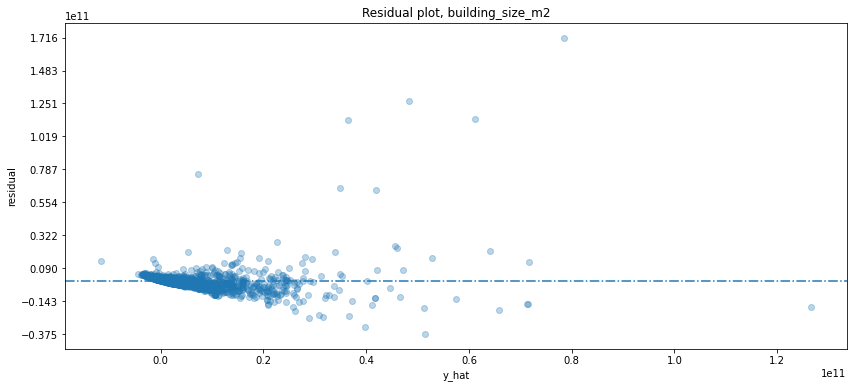

In [126]:
y_hat = results.predict(train_set_transfd)
resid = train_set_transfd.price_in_rp - y_hat
# matpltlib plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(x=y_hat, y=resid, alpha=0.3)
ax.axhline(y=resid.mean(), linestyle='-.')
ax.set_title('Residual plot, building_size_m2')
ax.set_yticks(np.linspace(resid.min(), resid.max(), 10))
ax.set_xlabel('y_hat')
ax.set_ylabel('residual')

In [127]:
results.summary().tables[0]

Dep. Variable:,price_in_rp,R-squared:,0.594
Model:,OLS,Adj. R-squared:,0.585
Method:,Least Squares,F-statistic:,71.99
Date:,"Mon, 31 Oct 2022",Prob (F-statistic):,0.00
Time:,14:56:39,Log-Likelihood:,-73600.
No. Observations:,3068,AIC:,1.473e+05
Df Residuals:,3006,BIC:,1.477e+05
Df Model:,61,,
Covariance Type:,nonrobust,,


In [128]:
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-7.57e+08,9.53e+08,-0.794,0.427,-2.63e+09,1.11e+09
C(certificate)[T.hp - hak pakai],5.971e+08,6.46e+09,0.092,0.926,-1.21e+10,1.33e+10
"C(certificate)[T.lainnya (ppjb,girik,adat,dll)]",7.388e+08,6.34e+08,1.165,0.244,-5.04e+08,1.98e+09
C(certificate)[T.shm - sertifikat hak milik],6.494e+08,5.17e+08,1.256,0.209,-3.64e+08,1.66e+09
C(property_condition)[T.bagus sekali],-1.056e+09,5e+08,-2.112,0.035,-2.04e+09,-7.57e+07
C(property_condition)[T.baru],6.884e+08,2.91e+08,2.365,0.018,1.18e+08,1.26e+09
C(property_condition)[T.butuh renovasi],1.815e+09,8.01e+08,2.266,0.024,2.44e+08,3.39e+09
C(property_condition)[T.sudah renovasi],-5.965e+08,5.95e+08,-1.002,0.316,-1.76e+09,5.7e+08
C(furnishing)[T.semi furnished],-3.35e+08,5.23e+08,-0.640,0.522,-1.36e+09,6.91e+08
C(furnishing)[T.unfurnished],1.495e+08,5.14e+08,0.291,0.771,-8.59e+08,1.16e+09


In [129]:
X_train['furnishing'].value_counts()

unfurnished       2135
semi furnished     726
furnished          207
Name: furnishing, dtype: int64

In [130]:
numerical_features = \
    X_train.select_dtypes(exclude=['object', 'category']).drop(['lat', 'long'], axis=1).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
f = 'price_in_rp ~ '\
    + ' + '.join(numerical_features) + ' + '
f = f + 'C(certificate, Treatment(reference=3)) + ' # `SHM` as reference
f = f + 'C(property_condition, Treatment(reference=3)) + ' # `butuh renovasi` as reference
f = f + 'C(furnishing, Treatment(reference=3)) + '  # `unfurnished` as reference
f = f + 'C(city, Treatment(reference=2))' # `Bekasi` as reference

lm = OLS.from_formula(f, data=train_set_transfd)
results = lm.fit()

PatsyError: specified level 3 is out of range

In [ ]:
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.495e+08,9.31e+08,1.020,0.308,-8.77e+08,2.78e+09
"C(certificate, Treatment(reference=3))[T.hgb - hak guna bangunan]",-4.938e+08,4.97e+08,-0.994,0.320,-1.47e+09,4.8e+08
"C(certificate, Treatment(reference=3))[T.hp - hak pakai]",-9.689e+07,6.37e+09,-0.015,0.988,-1.26e+10,1.24e+10
"C(certificate, Treatment(reference=3))[T.lainnya (ppjb,girik,adat,dll)]",1.121e+07,4.16e+08,0.027,0.979,-8.04e+08,8.27e+08
"C(property_condition, Treatment(reference=3))[T.bagus]",-3.296e+06,7.75e+08,-0.004,0.997,-1.52e+09,1.52e+09
"C(property_condition, Treatment(reference=3))[T.bagus sekali]",-1.348e+09,8.78e+08,-1.536,0.125,-3.07e+09,3.72e+08
"C(property_condition, Treatment(reference=3))[T.baru]",4.509e+08,7.92e+08,0.569,0.569,-1.1e+09,2e+09
"C(property_condition, Treatment(reference=3))[T.semi furnished]",-1.378e+09,1.33e+09,-1.036,0.300,-3.99e+09,1.23e+09
"C(property_condition, Treatment(reference=3))[T.sudah renovasi]",-7.548e+08,9.37e+08,-0.806,0.421,-2.59e+09,1.08e+09
"C(property_condition, Treatment(reference=3))[T.unfurnished]",1.259e+09,1.23e+09,1.026,0.305,-1.15e+09,3.67e+09
